In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from   astropy.io import fits
import math

dir = '/Users/throop/Data/NH_MVIC_Ring/'
file_ring = dir + 'ringdep_mos_v1_wcs_header_pl.fits'

d2r = 2*math.pi / 360.

# Define the brightness of the ring
dn_ring = 0.03

# Define the latitude of the observer. Usually we will look it up from SPICE.

lat_obs = 43.2  # In degrees

# Open file
hdulist = fits.open(file_ring)



In [2]:
# Define DN → I/F conversion
def dn2iof(dn, exptime, pixfov, rsolar):
    # Calculate MVIC pixel size, in sr

    sr_pix       = (pixfov*(1e-6))**2  # Angular size of each MVIC pixel, in sr

    # Look up the solar flux at 1 AU, using the solar spectral irradiance at 
    #    http://rredc.nrel.gov/solar/spectra/am1.5/astmg173/astmg173.html
    # or http://www.pas.rochester.edu/~emamajek/AST453/AST453_stellarprops.pdf

    f_solar_1au_si     = 1.77                 # W/m2/nm. At 600 nm. 
    f_solar_1au_cgs    = f_solar_1au_si * 100 # Convert from W/m2/nm to erg/sec/cm2/Angstrom
                                              # Unit conv. is correct -- see python code below.

    f_solar_1au        = f_solar_1au_cgs

    # Calculate the solar flux at Pluto's distance. [Actual distance is 33.8 AU]

    f_solar_40au       = f_solar_1au / (33.8**2)  # Use 1/r^2, not 1/(4pi r^2)

    # Use constants (from Level-2 files) to convert from DN, to intensity at detector.

    # This is the equation in ICD @ 62.

    i_per_sr    = dn / exptime / rsolar # Convert into erg/cm2/s/sr/Angstrom.

    # Because the ring is spatially extended, it fills the pixel, so we mult by pixel size
    # to get the full irradiance on the pixel.
    # *** But, somehow, this is not working. I get the right answer only if I ignore this 'per sr' factor.

    DO_OVERRIDE = True  # If true, ignore the missing factor of 'per sr' that seems to be in the conversion

    i           = i_per_sr * sr_pix     # Convert into erg/cm2/s/Angstrom

    if (DO_OVERRIDE):
        i = i_per_sr

    # Calculate "I/F". This is not simple the ratio of I over F, because F in the eq is not actually Flux.
    # "pi F is the incident solar flux density" -- ie, "F = solar flux density / pi"
    # SC93 @ 125

    iof = i / (f_solar_40au / math.pi)
    
    return iof


In [3]:
# Set up some conversion constants. These are mostly in the FITS header file.

exptime      = float(hdulist['PRIMARY'].header['EXPTIME']) # # All MVIC Framing ring mosaics are 10 sec/exposure
                                        
pixfov       = float(hdulist['PRIMARY'].header['PIXFOV'])# 19.8065   # Plate scale in microrad/pix    
rsolar       = float(hdulist['PRIMARY'].header['RSOLAR']) # 100190.64. # (DN/s)/(erg/cm^2/s/Ang/sr)
                         # RSOLAR is conversion for solar spectrum. Use for resolved sources.

## Convert the ring DN into I/F

In [4]:
iof_ring = dn2iof(dn_ring, exptime, pixfov, rsolar)

# Now get optical depth, using equation I/F = tau omega P / (4 mu)

omega_0 = 0.3        # Single scattering albedo. Rough guess.
p11     = 10         # Phase function (normalized). This is a guess for forward-scattering.
                     # http://nit.colorado.edu/atoc5560/week8.pdf
                     # Or better: fig 4.8 of Wendisch & Yang book (from Google Books)

tau_ring = iof_ring * 4 * np.cos(lat_obs) / omega_0 / p11


In [5]:
print "Ring upper limit: DN = {:.3g}, I/F = {:.2g}, tau = {:.2g}.".format(dn_ring, iof_ring, tau_ring)
print " Assuming omega_0 = {}, p11 = {}".format(omega_0, p11)

Ring upper limit: DN = 0.03, I/F = 6.1e-07, tau = 5.7e-07.
 Assuming omega_0 = 0.3, p11 = 10


## Now do a check of this conversion for a region of SP on Pluto

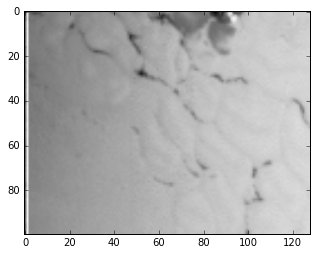

In [6]:
file = dir + 'mpf_0299175045_0x548_sci_1.fit'

hdu_sp = fits.open(file)
header = hdu_sp['PRIMARY'].header

exptime = float(header['EXPTIME'])
rpluto  = float(header['RPLUTO']) # (DN/s)/(erg/cm^2/s/Ang/sr), Pluto spectrum  
rsolar  = float(header['RSOLAR']) # (DN/s)/(erg/cm^2/s/Ang/sr), Solar spectrum 
ppluto  = float(header['PPLUTO'])
pixfov  = float(header['PIXFOV'])

im_sp = hdu_sp['PRIMARY'].data
im_spe = (np.transpose(im_sp[0,:,2700:2800]))  # Extract of SP image

plt.imshow(im_spe, cmap = 'Greys_r')
plt.show()

dn_sp = np.median(im_spe)  # Calculate the median value of this region of SP, in DN

iof_sp = dn2iof(dn_sp, exptime, pixfov, rpluto) # Convert from DN to I/F

iof_sp_known = 0.6 # From fig. 1F of Nature paper: max of (I/F)_sp ~ 0.6


In [7]:
print "Pluto surface: DN = {:.2f}, I/F = {:.2f}.".format(dn_sp, iof_sp)

Pluto surface: DN = 994.71, I/F = 0.42.


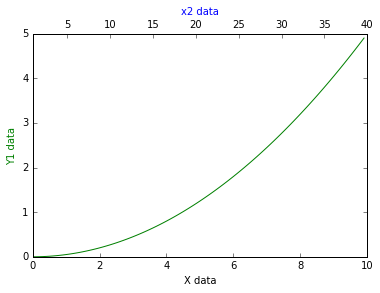

In [83]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 10, 0.1)
y1 = 0.05 * x**2
y2 = -1 *y1

fig, ax1 = plt.subplots()

ax2 = ax1.twiny()
ax1.plot(x, y1, 'g-')
# ax2.plot(x, y2, 'b-')

ax1.set_ylabel('Y1 data', color='g')
ax1.set_xlabel('X data')
ax1.set_xlim((0,10))


ax2.set_xlabel('x2 data', color='b')  # Top
ax2.set_xlim((1,40))

plt.show()